# 1D Schrödinger equation on LUCIDAC

This notebook demonstrates how to use *lucipy* to define the circuit for solving a simple quantum mechanical problem given by the time-indepentent Schrödinger equation in one spatial dimension and the typical anlog computing approach where analog computer time is mapped onto a physical coordinate (dimension). This is loosely connected to the [Analog Paradigm Application Note 22](https://analogparadigm.com/downloads/alpaca_22.pdf). This is also somewhat similar to this [Wolfram Demo: Energies for Particle in a Gaussian Potential Well](https://demonstrations.wolfram.com/EnergiesForParticleInAGaussianPotentialWell/).

The approach chosen is called [Shooting method](https://en.wikipedia.org/wiki/Shooting_method) and reduces the initial value boundary problem (IVBP) to an initial value problem (IVP) by trying out parameters until the boundary requirements are met. It is a classical method to solve the Schrödingers equation, i.e. it is one way to solve the Eigenvalue problem by determining the unknown Eigenvalue $E$ at the same time as the eigenvector and wave function $\Psi(t)$. Note that we work here with a purely real-valued $\Psi$.

## The anatomy about solutions in our setting

Solutions are bound wave functions $\Psi(t)$. Bound means $\int_{-\infty}^{\infty} \Psi(t)\mathrm d t=1$. Wave functions vanish outside of an infinitely deep potential well and do so approximately for a finite one. That means $\Psi(t)\to 0$ for the simulation boundaries.

The problem has no analytical solution but it is easy to find ones numerically. The expected solutions (wave forms) $\Psi(t)$

* are symmetric (around the center of the well) because our $V$ is also chosen symmetric
* have a nonzero $\Psi(0)$
* have a $\Psi'(0) < 0$ close to zero (somewhat similar to a Gaussian)



In [115]:
from lucipy import Circuit

In [29]:
from pylab import *
%matplotlib inline

## Modeling the potential well

We choose a Gaussian potential well because it is easy to compute on LUCIDAC. In contrast, a square well needs comparators which are not available on LUCIDAC. In the following code snippets we explore how to design the well and how to compute it from an ordinary differential equation. In principle the idea is that we know we want to have some $G(t) = e^{-(t-t_c)^2/w}$, we can just determine $G'(t)$ analytically and then obtain $G(t)$ by solving $\int G = G'(t)$ on LUCIDAC -- or here with `solve_ivp`.

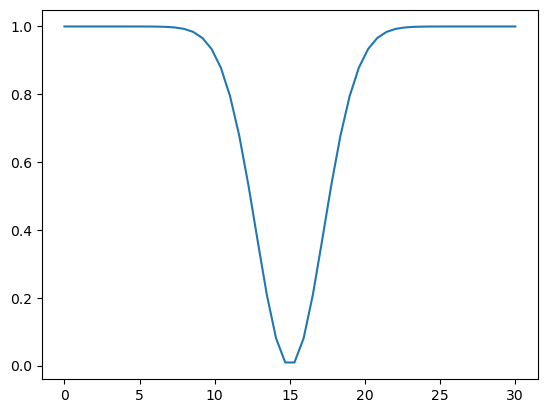

In [21]:
t_final = 30
t_center = t_final/2
t = linspace(0, t_final)
plot(t, 1-exp( -(t-t_center)**2 / 10) )

Unfortunately the ODE approach is very sensitive for the initial conditions, as we are effectively evolving an exponential. Therefore it is hard to generate a symmetrical Gaussian as it is plotted above. Instead, we have to restrict to the *right* side of the simulation domain, straight from the *center* of the well. However, this also makes it difficult to use the ordinary shooting method which exploits the sensitivity of parameters around the zero.

In [23]:
from scipy.integrate import solve_ivp

In [61]:
t_final=10
t_center=0
width=3
result = solve_ivp(lambda t,y: [1, -2/width*(y[0]-t_center)*y[1]], [0,t_final], [0, 1])
assert np.allclose(result.t, result.y[0]), "Could not integrate time as variable"
result

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  9.990e-04 ...  9.746e+00  1.000e+01]
        y: [[ 0.000e+00  9.990e-04 ...  9.746e+00  1.000e+01]
            [ 1.000e+00  1.000e+00 ...  1.383e-06  2.762e-07]]
      sol: None
 t_events: None
 y_events: None
     nfev: 170
     njev: 0
      nlu: 0

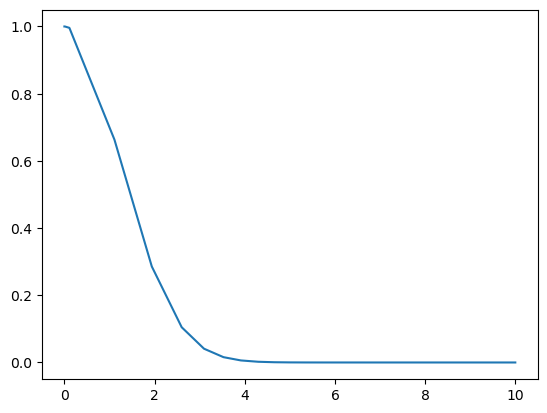

In [121]:
plot(result.t, result.y[1]);

## Solving the SDE with this Well

We now combine the ODE above with the SDE:

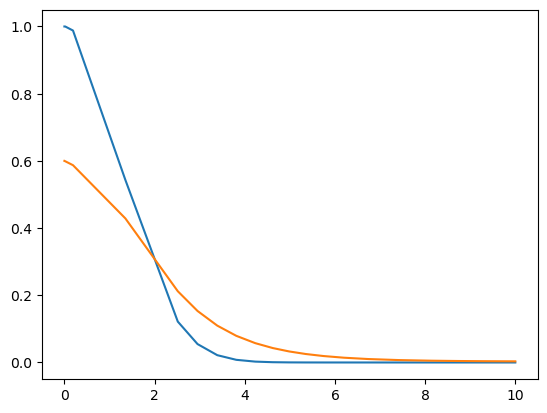

In [123]:
m, hbar, E = 1, 1, 0.4
def sde(t, y, E=E):
    t, V, dpsi, psi = y
    phi = 2*m/hbar*(V-E)
    dV = -2/width*(t-t_center)*V # results in V=exp( -(t-tc)**2 / width)
    return [ 1, dV, phi*dpsi, dpsi ]

res = solve_ivp(sde, [0, t_final], [0, 1, -0.06, 0.6])
t, V, dpsi, psi = res.y
plot(t, V)
plot(t, psi);

## Turning the potentiometer knobs

We can have some interactivity to play around with the parameters. Note this requires a running notebook and won't run in a static render such as in the Sphinx documentation generator.

In [91]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [111]:
def f(E, dpsi0, psi0):
    res = solve_ivp(lambda t,y: sde(t,y,E), [0, t_final], [0, 1, -dpsi0, psi0])
    t, V, dpsi, psi = res.y
    plot(t, V)
    plot(t, psi)
    axhline(0)
    title(f"{E=}, {dpsi0=}, {psi0=}")

In [124]:
interact(f,
         E=widgets.FloatSlider(value=0.8, min=0, max=3, step=0.1),
         dpsi0=widgets.FloatSlider(value=0.2, min=-0.5, max=0.5, step=0.01),
         psi0=widgets.FloatSlider(min=0, max=3, step=0.1),
        );

interactive(children=(FloatSlider(value=0.8, description='E', max=3.0), FloatSlider(value=0.2, description='dp…